# Estimating errors between two trajectories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import validator as validator
from utils import *
from matplotlib.ticker import MaxNLocator

In [11]:
dist, dist_to_line = distance, distance_to_line

def find_next_focus_point1(p1, p2, q1, q2):
    """
    The closest point (p2 or q2) to the two current points (p1 or q1)
    Returns: True if p2 is the next focus point, False if q2
    """
    return min(dist(p2, p1), dist(p2, q1)) < min(dist(q2, p1), dist(q2, q1)) #p2 is the closest point

def find_next_focus_point2(p1, p2, q1, q2):
    """
    The closest point (p2 or q2) to its respective point (p1 or q1)
    """
    return dist(p2, p1) < dist(q2, q1) #p2 is the closest point
    
def find_next_focus_point3(p1, p2, q1, q2):
    """
    distance between p2 (or q1) and the line (p1q1) 
    """
    return dist_to_line(*(p1, q1), p2) < dist_to_line(*(p1, q1), q2)


def find_next_focus_point4(p1, p2, q1, q2, oldpoint):
    """
    distance between p2 (or q1) and the line (p1q1) 
    """
    wrong_side = orientation(p1, q1, oldpoint)
    if orientation(p1, q1, p2) == wrong_side:
        return False
    elif orientation(p1, q1, q2) == wrong_side:
        return True
    else:
        return dist_to_line(*(p1, q1), p2) < dist_to_line(*(p1, q1), q2)

### *Idea 2* -  separation of cases when changing orientation

In [12]:
def error_btw_trajectories(S, T):
    i, j = 0, 0 # i (or j) is the index of the current point along S (or T)
    si, tj = S[i], T[j]
    plt.figure()
    plt.plot(*S.transpose(), '-o', *T.transpose(), '-o')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid()
    error, old_point, dir_point = 0, si, (si + tj) / 2
    while i < len(S) - 1 and j < len(T) - 1:
#         plt.show()
#         plt.figure()
#         plt.plot(*S.transpose(), '-o', *T.transpose(), '-o')
#         ax = plt.gca()
#         ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#         ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid()
#         print(i, j, si, S[i+1], tj, T[j+1])
        # 1. Check whether or not there is an intersection between the two next segments
        intersect = intersection_btw_segs(si, S[i+1], tj, T[j+1])
        if np.all(intersect != np.inf): # if the segments [S_i, S_i+1] and [T_i, T_i+1] intersect
#             print(">> Intersection")
            # Compute area of the triangle intersect, si, tj
            error += triangle_area(si, tj, intersect, ax)
            plt.plot(*intersect, 'og')
            if find_next_focus_point3(si, S[i+1], tj, T[j+1]):
                old_point = si
                dir_point = (si + tj)/2 # TODO : is this a good idea ??????????
                si, i = S[i+1], i+1
                tj = intersect
            else:
                old_point = tj
                dir_point = (si + tj)/2 # TODO : is this a good idea ??????????
                tj, j = T[j+1], j+1
                si = intersect
        # If there is no intersection, we have to check the orientation of the two next points
        else:
            orientation_s, orientation_t = orientation(si, tj, S[i+1]), orientation(si, tj, T[j+1])
#             print("orientation", orientation_s, orientation_t)
            if orientation_s == 0 and orientation_t == 0:
#                 print("Strange ...")
                if find_next_focus_point3(si, S[i+1], tj, T[j+1]):
                    old_point, dir_point = si, si
                    si, i = S[i+1], i+1
                else:
                    old_point, dir_point = tj, tj
                    tj, j = T[j+1], j+1
            elif orientation_s == orientation_t or orientation_s == 0 or orientation_t==0:
#                 print("old point", old_point, "dir_point", dir_point)
                #simple case : S[i+1] and T[j+1] are on the side of the line (si, tj)
                if orientation_s == 0 or find_next_focus_point4(si, S[i+1], tj, T[j+1], dir_point):
                    old_point, dir_point = si, si
                    si, i = S[i+1], i+1
                else:
                    old_point, dir_point = tj, tj
                    tj, j = T[j+1], j+1
            else : #one point is on the "wrong" side of the line 
#                 print(">> chgt d'angle")
                wrong_side = orientation(si, tj, dir_point) # TODO consider the case when oldpoint==si==tj
                if wrong_side == 0:
                    print("TODO ...")
                    input()
                elif orientation_s == wrong_side: # we have to find the intersection between the line (si,S[i+1]) and a segment of T
                    intersect = intersection_btw_line_seg(si, S[i+1], tj, T[j+1])
                    if np.all(intersect == np.inf):
                        old_point = tj
                        tj, j = T[j+1], j+1
                    elif np.all(intersect == - np.inf):
                        print("Erreur dans l'algo A")
                        print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side)
                        input()
                    else:
                        old_point, tj = tj, intersect
#                         tj = intersect
                        error += triangle_area(old_point, si, tj, ax)
                        si, i = S[i+1], i+1 #TODO deplacer directement le pivot si
                        old_point = si
                elif orientation_t == wrong_side: # we have to find the intersection between the line (si,S[i+1]) and a segment of S
                    intersect = intersection_btw_line_seg(tj, T[j+1], si, S[i+1])
                    if np.all(intersect == np.inf):
                        old_point = si
                        si, i = S[i+1], i+1
                    elif np.all(intersect == - np.inf):
                        print("Erreur dans l'algo B")
                        print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side, old_point)
                        input()
                    else:
                        old_point, si = si, intersect
#                         si = intersect
                        error += triangle_area(old_point, si, tj, ax)
                        tj, j = T[j+1], j+1
                        old_point = tj
                else:
                    print("There is a problem ?")
                    print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side)
                    input()

            # Compute area of the triangle old_point, si, tj
            error += triangle_area(old_point, si, tj, ax)
#         plt.plot(*si, 'rx')
#         plt.plot(*tj, 'rx')
#         plt.plot(*old_point, 'kx')
#         plt.plot(*dir_point, 'cx')
    
    if i == len(S) - 1:
        error += triangle_area(si, tj, T[j+1], ax)
        j += 1
        for j in range(j, len(T)-1):
            error += triangle_area(si, T[j], T[j+1], ax)
    elif j == len(T) - 1: #else ?
        error += triangle_area(tj, si, S[i+1], ax)
        i += 1
        for i in range(i, len(S)-1):
            error += triangle_area(tj, S[i], S[i+1], ax)
    plt.show()
    Slen = sum(norm(S[i+1] - S[i]) for i in range(len(S) - 1))
    return error / Slen

SR1.txt	

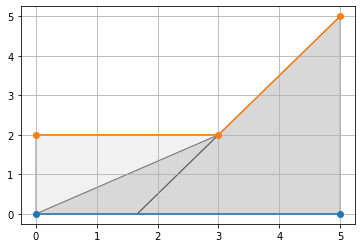

ok 	 The expected value is indeed 2.6

SR2.txt	

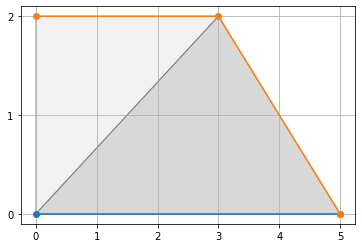

ok 	 The expected value is indeed 1.6

SR3.txt	

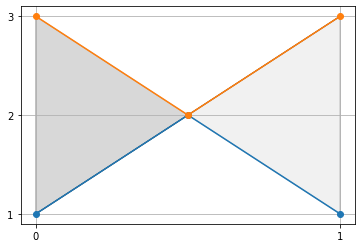

ok 	 The expected value is indeed 0.4472135954999579

SR4.txt	

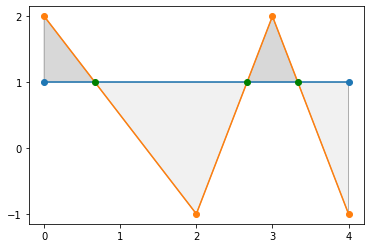

NOT ok 	 The expected value is 0.83, but the output value is 0.8333333333333335.

SR5.txt	

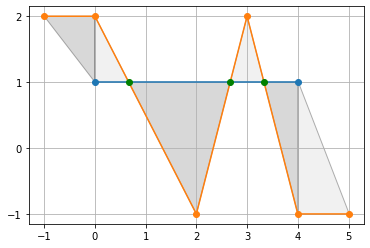

ok 	 The expected value is indeed 1.2083333333333333

SR6.txt	

/home/jean/Documents/M1/CSintro/err_btw_trajectories/utils.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return abs(b*B[1] - a*B[0] - c)/np.hypot(a, b)


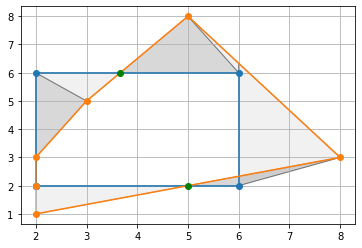

NOT ok 	 The expected value is 0.6325, but the output value is 0.6979166666666665.

[test0]simple.txt	

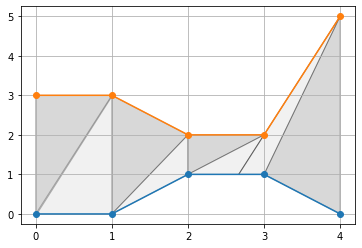

NOT ok 	 The expected value is 1.8639, but the output value is 1.8639610306789278.

[test1]negative.txt	

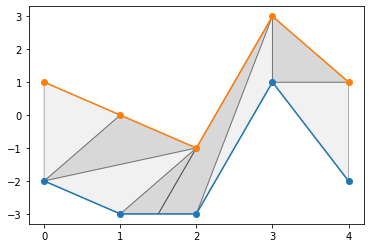

NOT ok 	 The expected value is 1.0309, but the output value is 1.030970684301985.

[test2]simple2.txt	

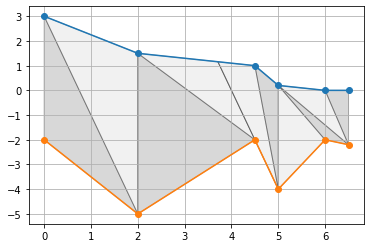

In [ ]:
validator.test(error_btw_trajectories, samples_range = slice(0, None))